In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Standard imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec

In [9]:
# Import OpenSense modules as submodules
import sys
import os

sys.path.append(os.path.abspath("./pycomlink/"))
sys.path.append(os.path.abspath("./poligrain/src/"))
sys.path.append(os.path.abspath("./mergeplg/src/"))

import pycomlink as pycml 
import poligrain as plg

# Data exploration

In [10]:
# load dataset
ds_cmls_openmrg_sum = xr.open_dataset("data/processed_cml_OpenMRG.nc")
ds_cmls_openmrg_meta = xr.open_dataset("data/andersson_2022_OpenMRG/openMRG_cml.nc")
tl_openmrg = ds_cmls_openmrg_meta.tsl - ds_cmls_openmrg_meta.rsl
ds_gauges_openmrg = xr.open_dataset("data/andersson_2022_OpenMRG/gauges/openmrg_gauges.nc")
ds_radar_openmrg_raw = xr.open_dataset("data/andersson_2022_OpenMRG/radar/radar.nc")
ds_radar_openmrg = xr.open_dataset("data/andersson_2022_OpenMRG/radar/openmrg_rad.nc")
ds_rad_along_cml_openmrg = xr.open_dataset("data/andersson_2022_OpenMRG/radar/radar_along_cml.nc")


ds_cmls_openrainer = xr.open_dataset("data/processed_cml_OpenRainER.nc")
ds_cmls_openrainer_meta = xr.open_dataset("data/covi_2024_OpenRainER/OpenRainER_cmls.nc")
tl_openrainer = ds_cmls_openrainer_meta.tsl - ds_cmls_openrainer_meta.rsl
ds_gauges_openrainer = xr.open_dataset("data/covi_2024_OpenRainER/AWS_rainfall.nc")
ds_radar_openrainer = xr.open_dataset("data/covi_2024_OpenRainER/openrainer_radar.nc")
ds_radar_openrainer_raw = xr.open_mfdataset("data/covi_2024_OpenRainER/RADrain_20220[6-8]*")
ds_rad_along_cml_openrainer = xr.open_dataset("data/covi_2024_OpenRainER/rad_along_cml.nc")

In [11]:
## prepare cdf data
# get hourly data
rain_gauges_orr = ds_gauges_openrainer.rainfall_amount.values.flatten()
rain_rad_along_cml_orr = ds_rad_along_cml_openrainer.rainfall_amount.resample(time='1h').sum().values.flatten()
rain_radar_orr = ds_radar_openrainer.rainfall_amount.resample(time='1h').sum().values.flatten()

rain_gauges_omrg = ds_gauges_openmrg.rainfall_amount.values.flatten()
rain_rad_along_cml_omrg = ds_rad_along_cml_openmrg.rainfall_amount.resample(time='1h').sum().values.flatten()
rain_radar_omrg = ds_radar_openmrg.rainfall_amount.resample(time='1h').sum().values.flatten()

# remove nan and values below 0.1 mm/h
threshold = 0.1
rain_gauges_orr = rain_gauges_orr[(~np.isnan(rain_gauges_orr)) & (rain_gauges_orr >= threshold)]
rain_rad_along_cml_orr = rain_rad_along_cml_orr[(~np.isnan(rain_rad_along_cml_orr)) & (rain_rad_along_cml_orr >= threshold)]
rain_radar_orr = rain_radar_orr[(~np.isnan(rain_radar_orr)) & (rain_radar_orr >= threshold)]

rain_gauges_omrg = rain_gauges_omrg[(~np.isnan(rain_gauges_omrg)) & (rain_gauges_omrg >= threshold)]
rain_rad_along_cml_omrg = rain_rad_along_cml_omrg[(~np.isnan(rain_rad_along_cml_omrg)) & (rain_rad_along_cml_omrg >= threshold)]
rain_radar_omrg = rain_radar_omrg[(~np.isnan(rain_radar_omrg)) & (rain_radar_omrg >= threshold)]


def get_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.linspace(0, 1, len(sorted_data))
    return sorted_data, cdf

x_g_orr, cdf_g_orr = get_cdf(rain_gauges_orr)
x_rc_orr, cdf_rc_orr = get_cdf(rain_rad_along_cml_orr)
x_r_orr, cdf_r_orr = get_cdf(rain_radar_orr)

x_g_omrg, cdf_g_omrg = get_cdf(rain_gauges_omrg)
x_rc_omrg, cdf_rc_omrg = get_cdf(rain_rad_along_cml_omrg)
x_r_omrg, cdf_r_omrg = get_cdf(rain_radar_omrg)

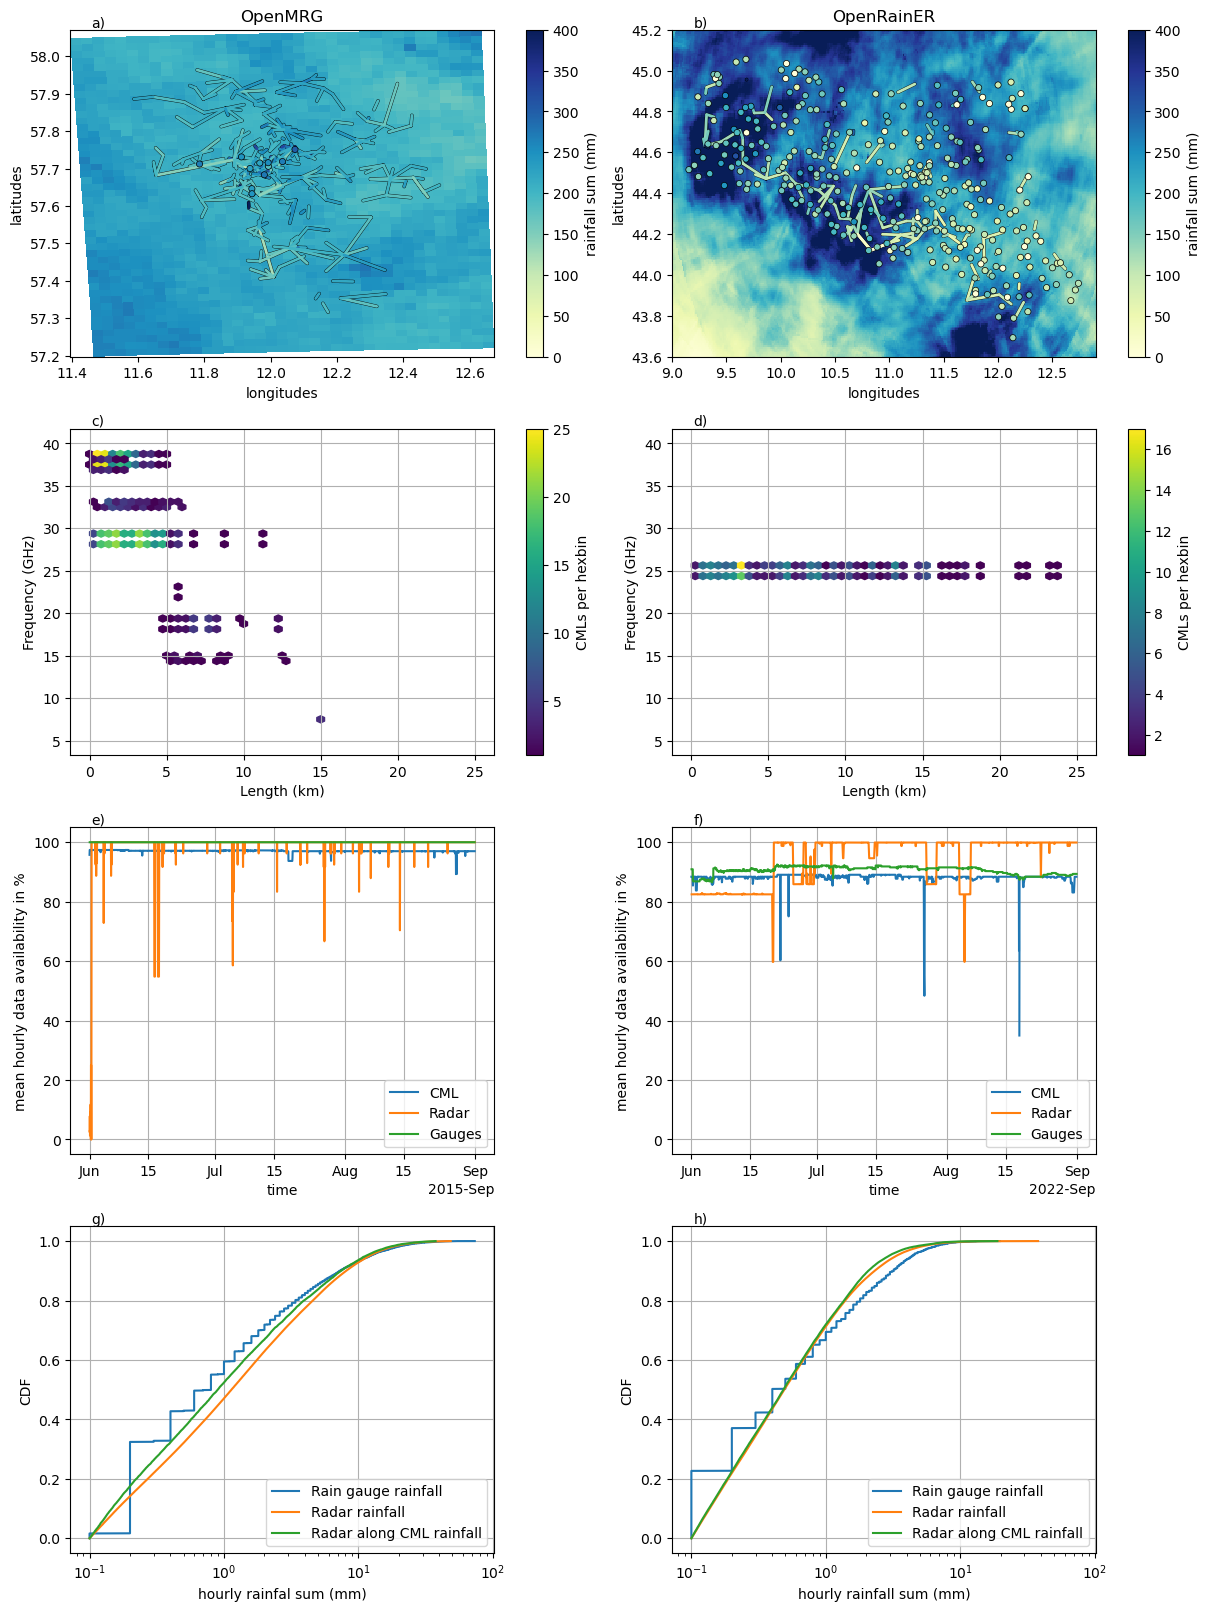

In [12]:
fig = plt.figure(figsize=(12, 16),constrained_layout=True)  


ax1 = fig.add_subplot(4, 2, 1)
plg.plot_map.plot_plg(
    da_grid=ds_radar_openmrg.rainfall_amount.sum(dim='time'),
    da_gauges=ds_gauges_openmrg.rainfall_amount.sum(dim='time'),
    da_cmls=ds_cmls_openmrg_sum.R_acc.sum(dim='time'),
    use_lon_lat=True,
    vmin=0,
    vmax=400,
    cmap="YlGnBu",
    colorbar_label="rainfall sum (mm)",
    ax=ax1,
)
ax1.set_title("OpenMRG")
ax1.set_xlabel("longitudes")
ax1.set_ylabel("latitudes")

ax2 = fig.add_subplot(4, 2, 2)
plg.plot_map.plot_plg(
    da_grid=ds_radar_openrainer.rainfall_amount.sum(dim='time'),
    da_gauges=ds_gauges_openrainer.rainfall_amount.sum(dim='time'),
    da_cmls=ds_cmls_openrainer.R_acc.sum(dim='time'),
    use_lon_lat=True,
    vmin=0,
    vmax=400,
    cmap="YlGnBu",
    colorbar_label="rainfall sum (mm)",
    ax=ax2,
)
ax2.set_ylim(43.6,45.2)
ax2.set_xlim(9,12.9)
ax2.set_title("OpenRainER")
ax2.set_xlabel("longitudes")
ax2.set_ylabel("latitudes")


ax3 = fig.add_subplot(4, 2, 3)

hexbin1 = plg.plot_metadata.plot_len_vs_freq_hexbin(
    ds_cmls_openmrg_meta.length, ds_cmls_openmrg_meta.frequency, gridsize=50,extent=[0,25,5,40], ax=ax3
)
plt.colorbar(hexbin1,ax=ax3,label='CMLs per hexbin')
ax3.grid()

ax4 = fig.add_subplot(4, 2, 4, sharex=ax3, sharey=ax3)
hexbin2 = plg.plot_metadata.plot_len_vs_freq_hexbin(
    ds_cmls_openrainer_meta.length, ds_cmls_openrainer_meta.frequency, gridsize=50,extent=[0,25,5,40], ax=ax4
)
plt.colorbar(hexbin2,ax=ax4,label='CMLs per hexbin')
ax4.grid()

ax5 = fig.add_subplot(4, 2, 5)


(((~tl_openmrg.isnull()).sum(dim=['cml_id','sublink_id']).resample(time='60min').sum()/(2*365*60)).isel(time=slice(None, -1))*100).plot(label='CML',ax=ax5)
(((~ds_radar_openmrg_raw.data.isnull()).sum(dim=['x','y'])/(37*48)).rolling(time=12, center=True).mean()*100).plot(label='Radar',ax=ax5)
(((~ds_gauges_openmrg.rainfall_amount.isnull()).sum(dim='id')/11)*100).plot(label='Gauges',ax=ax5)
ax5.set_ylabel('mean hourly data availability in %')
ax5.legend(loc='lower right')
ax5.set_xlabel("time")
ax5.grid()

ax6 = fig.add_subplot(4, 2, 6, sharey=ax5)
(((~tl_openrainer.isnull()).sum(dim=['cml_id','sublink_id']).resample(time='60min').sum()/(2*151*60)).isel(time=slice(None, -1))*100).plot(label='CML',ax=ax6)
(((~ds_radar_openrainer_raw.rainfall_amount.isnull()).sum(dim=['lon','lat'])/(290*373)).rolling(time=12, center=True).mean()*100).plot(label='Radar',ax=ax6)
(((~ds_gauges_openrainer.rainfall_amount.isnull()).sum(dim='id')/319)*100).plot(label='Gauges',ax=ax6)
ax6.set_xlabel("time")
ax6.legend(loc='lower right')
ax6.set_ylabel('mean hourly data availability in %')
ax6.grid()

ax7 = fig.add_subplot(4, 2, 7)
ax7.plot(x_g_orr, cdf_g_orr, label="Rain gauge rainfall ")
ax7.plot(x_r_orr, cdf_r_orr, label="Radar rainfall")
ax7.plot(x_rc_orr, cdf_rc_orr, label="Radar along CML rainfall")
ax7.set_xlabel("hourly rainfal sum (mm)")
ax7.set_ylabel("CDF")
ax7.legend(loc='lower right')
ax7.set_xscale("log")
ax7.grid()

ax8 = fig.add_subplot(4, 2, 8, sharey=ax7, sharex=ax7)
ax8.plot(x_g_omrg, cdf_g_omrg, label="Rain gauge rainfall ")
ax8.plot(x_r_omrg, cdf_r_omrg, label="Radar rainfall")
ax8.plot(x_rc_omrg, cdf_rc_omrg, label="Radar along CML rainfall")
ax8.set_xlabel("hourly rainfall sum (mm)")
ax8.set_ylabel("CDF")
ax8.legend(loc='lower right')
ax8.set_xscale("log")
ax8.grid()


axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
titles = ["OpenMRG", "OpenRainER", " ", " ", " ", " ", " ", " "]

for ax, label, title in zip(axes, "abcdefgh", titles):
    ax.text(0.05, 1.01, f"{label})", transform=ax.transAxes)
    ax.set_title(title)

fig.savefig('Fig1.png', dpi=300, bbox_inches='tight')

# SCORE COMPARISON

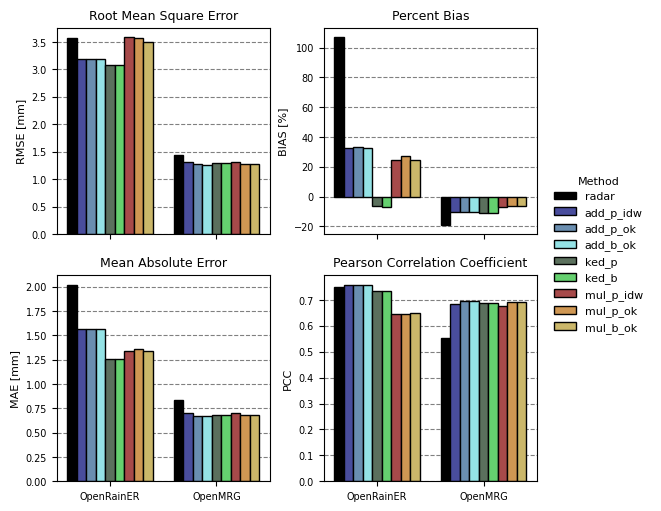

In [13]:
# Load data
data_ER = pd.read_csv('metrics_OpenRainER.csv')
data_GT = pd.read_csv('metrics_OpenMRG.csv')
data = pd.concat([data_ER, data_GT], ignore_index=True)

# Metrics & titles
metrics = [
    'root_mean_square_error',
    'percent_bias',
    'mean_absolute_error',
    'pearson_correlation_coefficient'
]
titles = [
    'Root Mean Square Error',
    'Percent Bias',
    'Mean Absolute Error',
    'Pearson Correlation Coefficient'
]

axis_names = [
    'RMSE [mm]',
    'BIAS [%]',
    'MAE [mm]',
    'PCC'
]

# Filter methods
methods_to_plot = ['radar', 'add_p_idw', 'add_p_ok', 
                   'add_b_ok', 'ked_p', 'ked_b',
                   'mul_p_idw', 'mul_p_ok', 'mul_b_ok']
filtered_data = data[data['method'].isin(methods_to_plot)]

# Custom palette
palette = {
    'radar': "#000000",
    'add_p_idw': "#3b41ab",
    'add_p_ok': "#5e8ebc",
    'add_b_ok': "#86eff3",
    'ked_p': "#57735a",
    'ked_b': "#53e261",
    'mul_p_idw': "#b73a3a",
    'mul_p_ok': "#e3993f",
    'mul_b_ok': "#dbc15a",
}

# --- Create figure with GridSpec ---
fig = plt.figure(figsize=(6.5, 5), constrained_layout=True)
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 0.5])

# --- Create shared x-axis subplots manually ---
ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1], sharex=ax00)
ax10 = fig.add_subplot(gs[1, 0], sharex=ax00)
ax11 = fig.add_subplot(gs[1, 1], sharex=ax00)
axes = [ax00, ax01, ax10, ax11]

# --- Plot each metric ---
for ax, metric, title, ax_name in zip(axes, metrics, titles, axis_names):
    sns.barplot(
        data=filtered_data,
        x='dataset', y=metric, hue='method',
        ax=ax, palette=palette, edgecolor='black'
    )
    ax.set_title(title, fontsize=9)
    ax.set_xlabel('', fontsize=8)
    ax.set_ylabel(ax_name, fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.get_legend().remove()
    ax.grid(linestyle='--', color='gray', axis='y')
    ax.set_axisbelow(True)

# --- Hide x-axis labels for top row ---
for ax in [ax00, ax01]:
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_xlabel('')

# --- Add single legend ---
handles, labels = ax00.get_legend_handles_labels()
legend_ax = fig.add_subplot(gs[:, 2])
legend_ax.axis('off')
legend_ax.legend(
    handles, labels, title='Method', fontsize=8, title_fontsize=8,
    loc='center', frameon=False
)

# --- Save & show ---
fig.savefig('metrics_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# RANGE CHECK ANALYSIS

<function matplotlib.pyplot.show(close=None, block=None)>

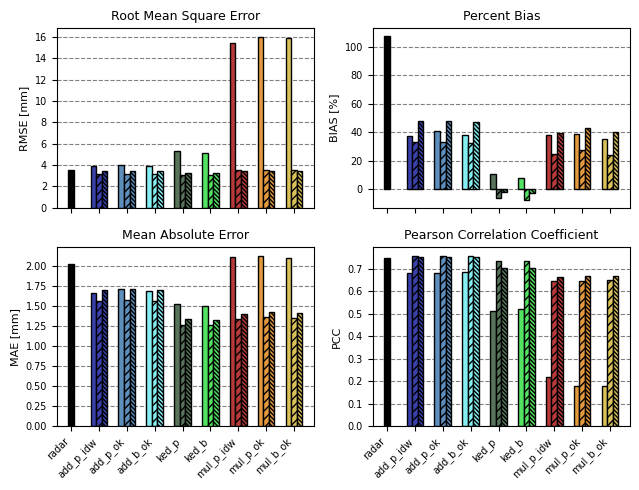

In [14]:
# Load data unchecked
data_ER_nc = pd.read_csv('metrics_OpenRainER_nc.csv')
data_ER_nc['status'] = np.full(len(data_ER_nc), 'no check')
data_ER_nc = data_ER_nc[data_ER_nc.method != 'radar']

# Load data baseline
data_ER = pd.read_csv('metrics_OpenRainER.csv')
data_ER['status'] = np.full(len(data_ER), 'baseline')

# Load data conservative check
data_ER_cc = pd.read_csv('metrics_OpenRainER_cc.csv')
data_ER_cc['status'] = np.full(len(data_ER_cc), 'conservative check')
data_ER_cc = data_ER_cc[data_ER_cc.method != 'radar']

data = pd.concat([data_ER_nc, data_ER, data_ER_cc])
data.reset_index(inplace=True)

data = data.drop(data[(data["method"] == "rainfall_radar") & (data["status"] == "conservative check")].index)
data = data.drop(data[(data["method"] == "rainfall_radar") & (data["status"] == "no check")].index)

metrics = ['root_mean_square_error', 'percent_bias',
           'mean_absolute_error','pearson_correlation_coefficient']
titles = ['Root Mean Square Error', 'Percent Bias',
           'Mean Absolute Error','Pearson Correlation Coefficient']
axis_names = ['RMSE [mm]', 'BIAS [%]', 'MAE [mm]', 'PCC']
statuses = ['no check', 'baseline', 'conservative check']

methods_to_plot = ['radar', 'add_p_idw', 'add_p_ok', 
                   'add_b_ok', 'ked_p', 'ked_b',
                   'mul_p_idw', 'mul_p_ok', 'mul_b_ok']

filtered_data = data[data['method'].isin(methods_to_plot)]

# Custom palette
palette = {
    'radar': "#000000",
    'add_p_idw': "#3b41ab",
    'add_p_ok': "#5e8ebc",
    'add_b_ok': "#86eff3",
    'ked_p': "#57735a",
    'ked_b': "#53e261",
    'mul_p_idw': "#b73a3a",
    'mul_p_ok': "#e3993f",
    'mul_b_ok': "#dbc15a",
}
# Define hatches for statuses
hatch_map = {
    'no check': '',
    'baseline': '////', 
    'conservative check': '\\\\\\\\\\\\\\\\'
}

fig, axes = plt.subplots(2, 2, figsize=(6.5, 5), sharex=True)
axes = axes.flatten()
width = 0.2
x = np.arange(len(list(methods_to_plot)))

for ax, metric, title, ax_name in zip(axes, metrics, titles, axis_names):
    for j, status in enumerate(statuses):
        values = []
        for method in list(methods_to_plot):
            df_status = filtered_data[filtered_data['status'] == status]
            if method == 'rainfall_radar' and status != 'baseline':
                values.append(np.nan)
            else:
                val = df_status[df_status['method'] == method][metric]
                values.append(val.values[0] if len(val) > 0 else np.nan)
        bars = ax.bar(x + j*width, values, width=width, edgecolor='black',
                      color=[palette.get(method) for method in list(methods_to_plot)])
        # Apply hatches
        for bar in bars:
            bar.set_hatch(hatch_map[status])

    ax.set_title(title, fontsize=9)
    ax.set_xticks(x + width)
    ax.set_xticklabels(list(methods_to_plot), rotation=45, ha='right', fontsize=7)
    ax.set_ylabel(ax_name, fontsize=8)
    ax.tick_params(axis='y', labelsize=7)
    ax.grid(linestyle='--', color='gray', axis='y')
    ax.set_axisbelow(True)

plt.tight_layout()
fig.savefig('rangecheck_analysis.png', dpi=300, bbox_inches='tight')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

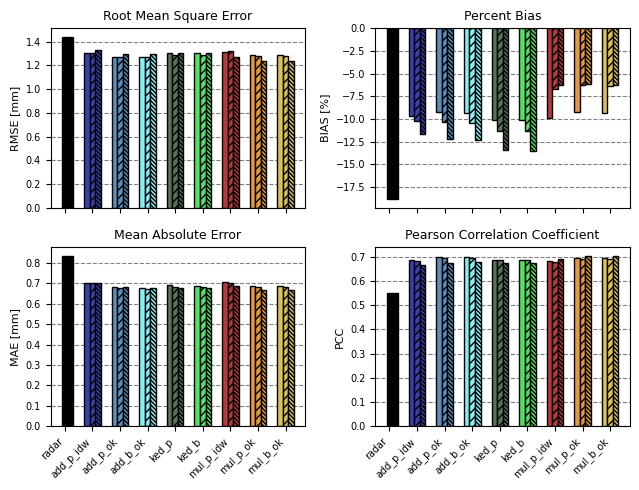

In [15]:
# Load data unchecked
data_GT_nc = pd.read_csv('metrics_OpenMRG_nc.csv')
data_GT_nc['status'] = np.full(len(data_GT_nc), 'no check')
data_GT_nc = data_GT_nc[data_GT_nc.method != 'radar']

# Load data baseline
data_GT = pd.read_csv('metrics_OpenMRG.csv')
data_GT['status'] = np.full(len(data_GT), 'baseline')

# Load data conservative check
data_GT_cc = pd.read_csv('metrics_OpenMRG_cc.csv')
data_GT_cc['status'] = np.full(len(data_GT_cc), 'conservative check')

data = pd.concat([data_GT_nc, data_GT, data_GT_cc])
data.reset_index(inplace=True)

data = data.drop(data[(data["method"] == "rainfall_radar") & (data["status"] == "conservative check")].index)
data = data.drop(data[(data["method"] == "rainfall_radar") & (data["status"] == "no check")].index)

metrics = ['root_mean_square_error', 'percent_bias',
           'mean_absolute_error','pearson_correlation_coefficient']
titles = ['Root Mean Square Error', 'Percent Bias',
           'Mean Absolute Error','Pearson Correlation Coefficient']
axis_names = ['RMSE [mm]', 'BIAS [%]', 'MAE [mm]', 'PCC']
statuses = ['no check', 'baseline', 'conservative check']

methods_to_plot = ['radar', 'add_p_idw', 'add_p_ok', 
                   'add_b_ok', 'ked_p', 'ked_b',
                   'mul_p_idw', 'mul_p_ok', 'mul_b_ok']

filtered_data = data[data['method'].isin(methods_to_plot)]

# Custom palette
palette = {
    'radar': "#000000",
    'add_p_idw': "#3b41ab",
    'add_p_ok': "#5e8ebc",
    'add_b_ok': "#86eff3",
    'ked_p': "#57735a",
    'ked_b': "#53e261",
    'mul_p_idw': "#b73a3a",
    'mul_p_ok': "#e3993f",
    'mul_b_ok': "#dbc15a",
}
# Define hatches for statuses
hatch_map = {
    'no check': '',
    'baseline': '////', 
    'conservative check': '\\\\\\\\\\\\\\\\'
}

fig, axes = plt.subplots(2, 2, figsize=(6.5, 5), sharex=True)
axes = axes.flatten()
width = 0.2
x = np.arange(len(list(methods_to_plot)))

for ax, metric, title, ax_name in zip(axes, metrics, titles, axis_names):
    for j, status in enumerate(statuses):
        values = []
        for method in list(methods_to_plot):
            df_status = filtered_data[filtered_data['status'] == status]
            if method == 'rainfall_radar' and status != 'baseline':
                values.append(np.nan)
            else:
                val = df_status[df_status['method'] == method][metric]
                values.append(val.values[0] if len(val) > 0 else np.nan)
        bars = ax.bar(x + j*width, values, width=width, edgecolor='black',
                      color=[palette.get(method) for method in list(methods_to_plot)])
        # Apply hatches
        for bar in bars:
            bar.set_hatch(hatch_map[status])

    ax.set_title(title, fontsize=9)
    ax.set_xticks(x + width)
    ax.set_xticklabels(list(methods_to_plot), rotation=45, ha='right', fontsize=7)
    ax.set_ylabel(ax_name, fontsize=8)
    ax.tick_params(axis='y', labelsize=7)
    ax.grid(linestyle='--', color='gray', axis='y')
    ax.set_axisbelow(True)

plt.tight_layout()
fig.savefig('rangecheck_analysis_MRG.png', dpi=300, bbox_inches='tight')
plt.show

# DISTANCE ANALYSIS

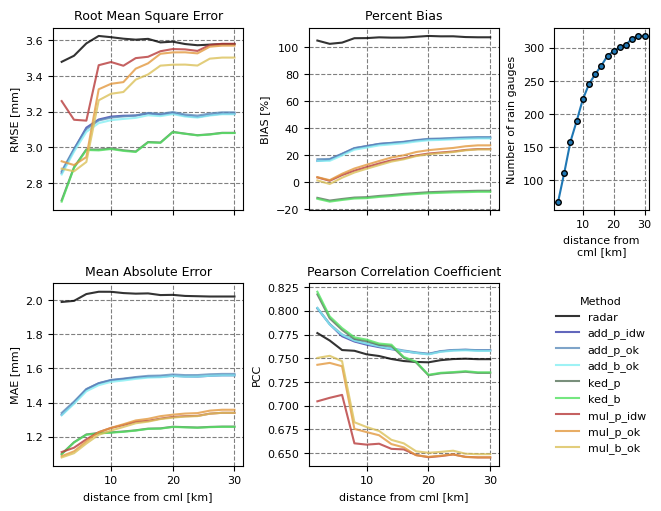

In [16]:
result_metric = pd.read_csv('metrics_distance.csv')
gauge_info = result_metric[['n_gauges', 'distance']].drop_duplicates().reset_index(drop=True)

fields = ['radar', 'add_p_idw', 'add_p_ok', 
          'add_b_ok', 'ked_p', 'ked_b',
          'mul_p_idw', 'mul_p_ok', 'mul_b_ok']

colors = ["#000000", "#3b41ab","#5e8ebc", 
          "#86eff3","#57735a", "#53e261",
          "#b73a3a",  "#e3993f", "#dbc15a"]

# Create figure with constrained_layout
fig = plt.figure(figsize=(6.5, 5), constrained_layout=True)
gs = gridspec.GridSpec(2, 3, figure=fig, width_ratios=[1, 1, 0.5])

# Subplots
ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1])
ax02 = fig.add_subplot(gs[0, 2])
ax10 = fig.add_subplot(gs[1, 0])
ax11 = fig.add_subplot(gs[1, 1])

handles = []

# --- RMSE ---
for field, color in zip(fields, colors):
    result = result_metric[result_metric.field == field]
    line, = ax00.plot(result.distance/1000, result.root_mean_square_error,
                      label=field, alpha=0.8, markersize=4, color=color)
    handles.append(line)

ax00.set_ylabel('RMSE [mm]', fontsize=8)
ax00.tick_params(axis='both', labelsize=8)
ax00.grid(linestyle='--', color='gray')
ax00.set_title('Root Mean Square Error', fontsize=9)
ax00.tick_params(axis='x', labelbottom=False)

# --- %BIAS ---
for field, color in zip(fields, colors):
    result = result_metric[result_metric.field == field]
    ax01.plot(result.distance/1000, result.percent_bias,
              alpha=0.8, markersize=4, color=color)

ax01.set_ylabel('BIAS [%]', fontsize=8)
ax01.tick_params(axis='both', labelsize=8)
ax01.grid(linestyle='--', color='gray')
ax01.set_title('Percent Bias', fontsize=9)
ax01.tick_params(axis='x', labelbottom=False)

# --- Number of rain gauges ---
ax02.plot(gauge_info.distance/1000, gauge_info.n_gauges, marker='o', markersize=4, markeredgecolor='black')
ax02.set_xlabel('distance from\ncml [km]', fontsize=8)
ax02.set_ylabel('Number of rain gauges', fontsize=8)
ax02.tick_params(axis='both', labelsize=8)
ax02.grid(linestyle='--', color='gray')

# --- MAE ---
for field, color in zip(fields, colors):
    result = result_metric[result_metric.field == field]
    ax10.plot(result.distance/1000, result.mean_absolute_error,
              alpha=0.8, markersize=4, color=color)

ax10.set_xlabel('distance from cml [km]', fontsize=8)
ax10.set_ylabel('MAE [mm]', fontsize=8)
ax10.tick_params(axis='both', labelsize=8)
ax10.grid(linestyle='--', color='gray')
ax10.set_title('Mean Absolute Error', fontsize=9)

# --- PCC ---
ax11.set_xlabel('distance from cml [km]', fontsize=8)
for field, color in zip(fields, colors):
    result = result_metric[result_metric.field == field]
    ax11.plot(result.distance/1000, result.pearson_correlation_coefficient,
              alpha=0.8, markersize=4, color=color)

ax11.set_ylabel('PCC', fontsize=8)
ax11.tick_params(axis='both', labelsize=8)
ax11.grid(linestyle='--', color='gray')
ax11.set_title('Pearson Correlation Coefficient', fontsize=9)

# --- Legend placed relative to the figure ---
fig.legend(handles, fields, title='Method',
           fontsize=8, title_fontsize=8,
           loc='center right', bbox_to_anchor=(1, 0.26),
           frameon=False, ncol=1)

# Save figure
plt.savefig('distance_analysis.png', dpi=600, bbox_inches='tight')
plt.show()

# INTENSITY ANALYSIS

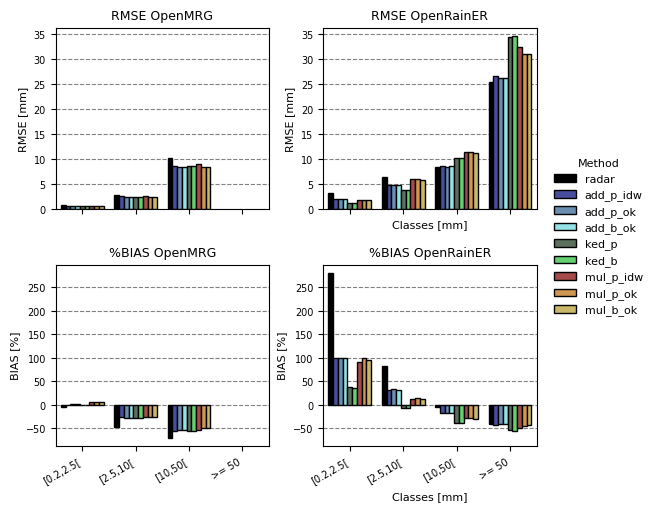

In [17]:
# --- Load data ---
data_ER = pd.read_csv('intensity_analysis_OpenRainER.csv')
data_GT = pd.read_csv('intensity_analysis_OpenMRG.csv')

# --- Filter methods ---
methods_to_plot = ['radar', 'add_p_idw', 'add_p_ok', 
                   'add_b_ok', 'ked_p', 'ked_b',
                   'mul_p_idw', 'mul_p_ok', 'mul_b_ok']
data_ER = data_ER[data_ER['field'].isin(methods_to_plot)]
data_GT = data_GT[data_GT['field'].isin(methods_to_plot)]

# --- Update palette to match renamed labels ---
palette = {
    'radar': "#000000",
    'add_p_idw': "#3b41ab",
    'add_p_ok': "#5e8ebc",
    'add_b_ok': "#86eff3",
    'ked_p': "#57735a",
    'ked_b': "#53e261",
    'mul_p_idw': "#b73a3a",
    'mul_p_ok': "#e3993f",
    'mul_b_ok': "#dbc15a",
}

# --- Figure layout (2×2 grid + narrow legend column) ---
fig = plt.figure(figsize=(6.5, 5), constrained_layout=True)
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 0.5])

# Create subplots with shared x-axis
ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1], sharex=ax00, sharey=ax00)
ax10 = fig.add_subplot(gs[1, 0], sharex=ax00)
ax11 = fig.add_subplot(gs[1, 1], sharex=ax00, sharey=ax10)
axes = [ax00, ax01, ax10, ax11]


# --- Plot 1: RMSE OpenMRG ---
sns.barplot(
    data=data_GT, x='class', y='root_mean_square_error', hue='field',
    ax=ax00, palette=palette, edgecolor='black'
)
ax00.set_title('RMSE OpenMRG', fontsize=9)
ax00.set_xlabel('', fontsize=8)
ax00.set_ylabel('RMSE [mm]', fontsize=8)
ax00.tick_params(axis='both', which='major', labelsize=7)
ax00.get_legend().remove()
ax00.grid(linestyle='--', color='gray', axis='y')

# --- Plot 2: RMSE OpenRainER ---
sns.barplot(
    data=data_ER, x='class', y='root_mean_square_error', hue='field',
    ax=ax01, palette=palette, edgecolor='black'
)
ax01.set_title('RMSE OpenRainER', fontsize=9)
ax01.set_xlabel('Classes [mm]', fontsize=8)
ax01.set_ylabel('RMSE [mm]', fontsize=8)
ax01.tick_params(axis='both', which='major', labelsize=7)
ax01.get_legend().remove()
ax01.grid(linestyle='--', color='gray', axis='y')

# --- Plot 3: %BIAS OpenMRG ---
sns.barplot(
    data=data_GT, x='class', y='percent_bias', hue='field',
    ax=ax10, palette=palette, edgecolor='black'
)
ax10.set_title('%BIAS OpenMRG', fontsize=9)
ax10.set_xlabel('', fontsize=8)
ax10.set_ylabel('BIAS [%]', fontsize=8)
ax10.tick_params(axis='both', which='major', labelsize=7)
ax10.get_legend().remove()
ax10.grid(linestyle='--', color='gray', axis='y')

# --- Plot 4: %BIAS OpenRainER ---
sns.barplot(
    data=data_ER, x='class', y='percent_bias', hue='field',
    ax=ax11, palette=palette, edgecolor='black'
)
ax11.set_title('%BIAS OpenRainER', fontsize=9)
ax11.set_xlabel('Classes [mm]', fontsize=8)
ax11.set_ylabel('BIAS [%]', fontsize=8)
ax11.tick_params(axis='both', which='major', labelsize=7)
ax11.get_legend().remove()
ax11.grid(linestyle='--', color='gray', axis='y')

# --- Hide x-axis labels for top row ---
for ax in [ax00, ax01]:
    plt.setp(ax.get_xticklabels(), visible=False)

# --- Add shared legend in narrow column ---
handles, labels = ax00.get_legend_handles_labels()
legend_ax = fig.add_subplot(gs[:, 2])
legend_ax.axis('off')
legend_ax.legend(
    handles, labels, title='Method', fontsize=8, title_fontsize=8,
    loc='center', frameon=False
)

# --- Rotate x-tick labels for bottom plots ---
for ax in [ax10, ax11]:
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

# place grid below barplot
for ax in axes:
    ax.set_axisbelow(True)

# --- Save & show ---
fig.savefig('intensity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

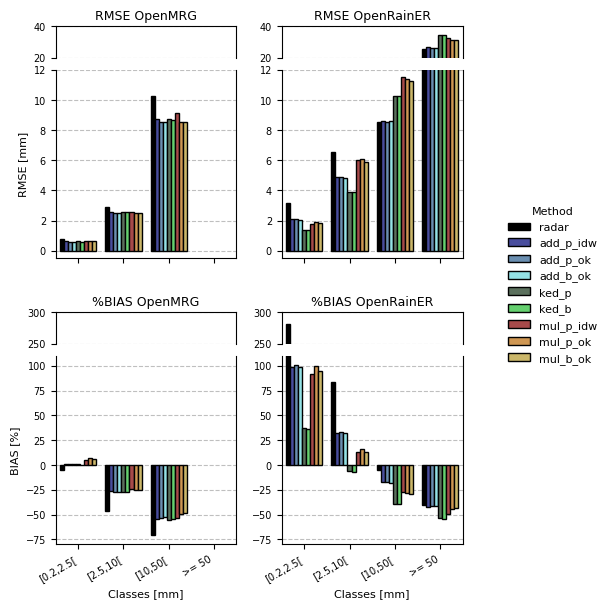

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Load data ---
data_ER = pd.read_csv('intensity_analysis_OpenRainER.csv')
data_GT = pd.read_csv('intensity_analysis_OpenMRG.csv')

# --- Filter methods to be plotted ---
methods_to_plot = ['radar', 'add_p_idw', 'add_p_ok', 
                   'add_b_ok', 'ked_p', 'ked_b',
                   'mul_p_idw', 'mul_p_ok', 'mul_b_ok']
data_ER = data_ER[data_ER['field'].isin(methods_to_plot)]
data_GT = data_GT[data_GT['field'].isin(methods_to_plot)]

# --- Define color palette for methods ---
palette = {
    'radar': "#000000",
    'add_p_idw': "#3b41ab",
    'add_p_ok': "#5e8ebc",
    'add_b_ok': "#86eff3",
    'ked_p': "#57735a",
    'ked_b': "#53e261",
    'mul_p_idw': "#b73a3a",
    'mul_p_ok': "#e3993f",
    'mul_b_ok': "#dbc15a",
}

# --- Create figure layout using GridSpec (broken axes design) ---
fig = plt.figure(figsize=(7, 7))
gs = fig.add_gridspec(4, 3, height_ratios=[0.5, 3, 0.5, 3], width_ratios=[1, 1, 0.5], 
                      hspace=0.3, wspace=0.3)

# Create subplots for each panel (upper and lower parts)
# RMSE OpenMRG (column 0)
ax00_upper = fig.add_subplot(gs[0, 0])
ax00_lower = fig.add_subplot(gs[1, 0], sharex=ax00_upper)

# RMSE OpenRainER (column 1)
ax01_upper = fig.add_subplot(gs[0, 1], sharex=ax00_upper)
ax01_lower = fig.add_subplot(gs[1, 1], sharex=ax00_upper)

# BIAS OpenMRG (column 0)
ax10_upper = fig.add_subplot(gs[2, 0], sharex=ax00_upper)
ax10_lower = fig.add_subplot(gs[3, 0], sharex=ax00_upper)

# BIAS OpenRainER (column 1)
ax11_upper = fig.add_subplot(gs[2, 1], sharex=ax00_upper)
ax11_lower = fig.add_subplot(gs[3, 1], sharex=ax00_upper)

for upper, lower in [
    (ax00_upper, ax00_lower),
    (ax01_upper, ax01_lower),
    (ax10_upper, ax10_lower),
    (ax11_upper, ax11_lower)
]:
    up_pos = upper.get_position()
    low_pos = lower.get_position()
    # avvicina leggermente le due parti
    upper.set_position([up_pos.x0, up_pos.y0 - 0.015, up_pos.width, up_pos.height])
    lower.set_position([low_pos.x0, low_pos.y0 + 0.015, low_pos.width, low_pos.height])

# --- Plot 1: RMSE OpenMRG ---
# Upper part (zoomed out range 20–35)
sns.barplot(data=data_GT, x='class', y='root_mean_square_error', hue='field',
            ax=ax00_upper, palette=palette, edgecolor='black')
ax00_upper.set_ylim([20, 40])
ax00_upper.set_title('RMSE OpenMRG', fontsize=9, pad=5)
ax00_upper.set_xlabel('')
ax00_upper.set_ylabel('')
ax00_upper.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax00_upper.tick_params(axis='y', labelsize=7)
ax00_upper.spines['bottom'].set_visible(False)
ax00_upper.grid(linestyle='--', color='gray', axis='y', alpha=0.5)
ax00_upper.set_axisbelow(True)

# Lower part (zoomed in range 0–12)
sns.barplot(data=data_GT, x='class', y='root_mean_square_error', hue='field',
            ax=ax00_lower, palette=palette, edgecolor='black', legend=False)
ax00_lower.set_ylim([-0.5, 12])
ax00_lower.set_xlabel('')
ax00_lower.set_ylabel('RMSE [mm]', fontsize=8)
ax00_lower.tick_params(axis='both', labelsize=7)
ax00_lower.tick_params(axis='x', labelbottom=False)
ax00_lower.spines['top'].set_visible(False)
ax00_lower.grid(linestyle='--', color='gray', axis='y', alpha=0.5)
ax00_lower.set_axisbelow(True)

# --- Plot 2: RMSE OpenRainER ---
# Upper part (20–35)
sns.barplot(data=data_ER, x='class', y='root_mean_square_error', hue='field',
            ax=ax01_upper, palette=palette, edgecolor='black', legend=False)
ax01_upper.set_ylim([20, 40])
ax01_upper.set_title('RMSE OpenRainER', fontsize=9, pad=5)
ax01_upper.set_xlabel('')
ax01_upper.set_ylabel('')
ax01_upper.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax01_upper.tick_params(axis='y', labelsize=7)
ax01_upper.spines['bottom'].set_visible(False)
ax01_upper.grid(linestyle='--', color='gray', axis='y', alpha=0.5)
ax01_upper.set_axisbelow(True)

# Lower part (0–12)
sns.barplot(data=data_ER, x='class', y='root_mean_square_error', hue='field',
            ax=ax01_lower, palette=palette, edgecolor='black', legend=False)
ax01_lower.set_ylim([-0.5, 12])
ax01_lower.set_xlabel('')
ax01_lower.set_ylabel('', fontsize=8)
ax01_lower.tick_params(axis='both', labelsize=7)
ax01_lower.tick_params(axis='x', labelbottom=False)
ax01_lower.spines['top'].set_visible(False)
ax01_lower.grid(linestyle='--', color='gray', axis='y', alpha=0.5)
ax01_lower.set_axisbelow(True)

# --- Plot 3: %BIAS OpenMRG ---
# Upper part (250–300)
sns.barplot(data=data_GT, x='class', y='percent_bias', hue='field',
            ax=ax10_upper, palette=palette, edgecolor='black', legend=False)
ax10_upper.set_ylim([250, 300])
ax10_upper.set_title('%BIAS OpenMRG', fontsize=9, pad=5)
ax10_upper.set_xlabel('')
ax10_upper.set_ylabel('')
ax10_upper.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax10_upper.tick_params(axis='y', labelsize=7)
ax10_upper.spines['bottom'].set_visible(False)
ax10_upper.grid(linestyle='--', color='gray', axis='y', alpha=0.5)
ax10_upper.set_axisbelow(True)

# Lower part (-80–110)
sns.barplot(data=data_GT, x='class', y='percent_bias', hue='field',
            ax=ax10_lower, palette=palette, edgecolor='black', legend=False)
ax10_lower.set_ylim([-80, 110])
ax10_lower.set_xlabel('Classes [mm]', fontsize=8)
ax10_lower.set_ylabel('BIAS [%]', fontsize=8)
ax10_lower.tick_params(axis='both', labelsize=7)
ax10_lower.spines['top'].set_visible(False)
ax10_lower.grid(linestyle='--', color='gray', axis='y', alpha=0.5)
ax10_lower.set_axisbelow(True)

# --- Plot 4: %BIAS OpenRainER ---
# Upper part (250–300)
sns.barplot(data=data_ER, x='class', y='percent_bias', hue='field',
            ax=ax11_upper, palette=palette, edgecolor='black', legend=False)
ax11_upper.set_ylim([250, 300])
ax11_upper.set_title('%BIAS OpenRainER', fontsize=9, pad=5)
ax11_upper.set_xlabel('')
ax11_upper.set_ylabel('')
ax11_upper.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax11_upper.tick_params(axis='y', labelsize=7)
ax11_upper.spines['bottom'].set_visible(False)
ax11_upper.grid(linestyle='--', color='gray', axis='y', alpha=0.5)
ax11_upper.set_axisbelow(True)

# Lower part (-80–110)
sns.barplot(data=data_ER, x='class', y='percent_bias', hue='field',
            ax=ax11_lower, palette=palette, edgecolor='black', legend=False)
ax11_lower.set_ylim([-80, 110])
ax11_lower.set_xlabel('Classes [mm]', fontsize=8)
ax11_lower.set_ylabel('', fontsize=8)
ax11_lower.tick_params(axis='both', labelsize=7)
ax11_lower.spines['top'].set_visible(False)
ax11_lower.grid(linestyle='--', color='gray', axis='y', alpha=0.5)
ax11_lower.set_axisbelow(True)

# --- Rotate x-axis labels for bottom row ---
for ax in [ax10_lower, ax11_lower]:
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

# --- Add shared legend in the third (narrow) column ---
handles, labels = ax00_upper.get_legend_handles_labels()
ax00_upper.get_legend().remove()

# Remove legends from all other subplots
for ax in [ax00_lower, ax01_upper, ax01_lower, ax10_upper, ax10_lower, ax11_upper, ax11_lower]:
    legend = ax.get_legend()
    if legend is not None:
        legend.remove()

# Add a dedicated legend axis
legend_ax = fig.add_subplot(gs[:, 2])
legend_ax.axis('off')
legend_ax.legend(
    handles, labels, title='Method', fontsize=8, title_fontsize=8,
    loc='center', frameon=False
)

# --- Save and show figure ---
fig.savefig('intensity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()